**YOUR NAME HERE**

Spring 2021

CS 252: Mathematical Data Analysis and Visualization

Project 7: Radial Basis Function Neural Networks

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=5)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

## Task 1: RBF Network development dataset

The eventual goal is to train a neural network so that it learns to recognize which human handwritten digit is shown in an image  (i.e. the numbers 0, 1, ..., 9). Before doing this, you will use simpler data to develop and debug your network.

### 1a. Load and preprocess data

- Load in the `rbf_dev_train.csv` and `rbf_dev_test.csv` train and test sets.
- For the train and test sets, separate the data variables (`X` and `Y`) from the class values (*class*). The test code below assumes the following names:
    - `y_train` and `y_test` for the class values in the train and test sets, respectively.
    - `rbf_dev_train` and `rbf_dev_test` for the train and test set data, respectively.
- Normalize each data feature "separately" between 0 and 1 (based on each feature's dynamic range).
    - Use the `min` and `max` values derived from the training set to normalize the test set. *This will ensure that identical feature values in the training and test sets get normalized to the same numeric value.*

**Tip:** It might be a good idea to write a few functions below so that you don't have a lot of duplicate code when processing train and test sets.

In [352]:
def scale_matrix(magnitudes):
    scale = np.eye(len(magnitudes) + 1)
    for i in range(len(magnitudes)):
        scale[i, i] = magnitudes[i]
    return scale

def translation_matrix(magnitudes):
    translation = np.eye(len(magnitudes) + 1)
    translation[:-1, -1] = np.array(magnitudes)
    return translation

def transform(C, data):
    homo = np.ones(data.shape[0])[:, np.newaxis]
    data_matrix = np.hstack([data, homo])
    transformed_data = (C@(data_matrix.T)).T[:, :-1]
    return transformed_data
    
def normalize_separately(train_data, test_data):
    max_vals = np.max(train_data, axis=0)
    min_vals = np.min(train_data, axis=0)
    scale_vector = [1/(max_vals[i] - min_vals[i])
                    for i in range(len(max_vals))]
    translation_vector = [-min_vals[i] for i in range(len(max_vals))]
    C = scale_matrix(
        scale_vector)@translation_matrix(translation_vector)
    normalized_train_data = transform(C, train_data)
    normalized_test_data = transform(C, test_data)
    
    return normalized_train_data, normalized_test_data

rbf_dev_train = np.genfromtxt('data/rbf_dev_train.csv',delimiter=",",skip_header=1)[:,:2]
rbf_dev_test = np.genfromtxt('data/rbf_dev_test.csv',delimiter=",",skip_header=1)[:,:2]
y_train = np.genfromtxt('data/rbf_dev_train.csv',delimiter=",",skip_header=1)[:,2].astype(int)
y_test = np.genfromtxt('data/rbf_dev_test.csv',delimiter=",",skip_header=1)[:,2].astype(int)

rbf_dev_train, rbf_dev_test = normalize_separately(rbf_dev_train, rbf_dev_test)


#### Preprocessing test code

The following test code is a good sanity check, but you are encouoraged to do additional testing to make sure that your preprocessing pipeline is working properly.

##### Check dtypes

In [184]:
print(f'Your training set is an ndarray? {isinstance(rbf_dev_train, np.ndarray)}')
print(f'Your training classes is an ndarray? {isinstance(y_train, np.ndarray)}')
print(f'Your test set is an ndarray? {isinstance(rbf_dev_test, np.ndarray)}')
print(f'Your test classes is an ndarray? {isinstance(y_test, np.ndarray)}')

Your training set is an ndarray? True
Your training classes is an ndarray? True
Your test set is an ndarray? True
Your test classes is an ndarray? True


##### Check shapes

In [185]:
print(f'Your training set shape is {rbf_dev_train.shape} and should be (1600, 2).')
print(f'Your training classes shape is {y_train.shape} and should be (1600,).')
print(f'Your test set shape is {rbf_dev_test.shape} and should be (400, 2).')
print(f'Your test classes shape is {y_test.shape} and should be (400,).')

Your training set shape is (1600, 2) and should be (1600, 2).
Your training classes shape is (1600,) and should be (1600,).
Your test set shape is (400, 2) and should be (400, 2).
Your test classes shape is (400,) and should be (400,).


##### Check dtypes (detailed)

Remove from assigned project

In [186]:
print(f'Your training set is an float? {isinstance(rbf_dev_train[0,0], float)}')
print(f'Your training classes is an int? {isinstance(y_train[0], np.int64)}')
print(f'Your test set is an float? {isinstance(rbf_dev_test[0,0], float)}')
print(f'Your test classes is an int? {isinstance(y_test[0], np.int64)}')

Your training set is an float? True
Your training classes is an int? True
Your test set is an float? True
Your test classes is an int? True


##### Check normalization (detailed)

Remove from assigned project

In [31]:
print(f'Your training set mins/maxs: {rbf_dev_train.min(axis=0)}/{rbf_dev_train.max(axis=0)}\nand should be                [0. 0.]/[1. 1.]')
print(f'Your test set mins/maxs: {rbf_dev_test.min(axis=0)}/{rbf_dev_test.max(axis=0)}\nand should be            [0.02038 0.01194]/[0.99805 0.98749]')

print(f'Training values look ok? {len(np.unique(rbf_dev_train)) > 2}')
print(f'Test values look ok? {len(np.unique(rbf_dev_test)) > 2}')

Your training set mins/maxs: [0. 0.]/[1. 1.]
and should be                [0. 0.]/[1. 1.]
Your test set mins/maxs: [0.02038 0.01194]/[0.99805 0.98749]
and should be            [0.02038 0.01194]/[0.99805 0.98749]
Training values look ok? True
Test values look ok? True


### 1b. Plot data

Create a scatter plot of the training data in the cell below.

- Color code each sample by its output class.
- Make the aspect ratio (height and width) of the x and y axes in the figure equal, otherwise the plot may look distorted.

If everything is working properly, you should see a jack-o-lantern whose eyes, noise, mouth, and stem are colored differently than the rest of the face.

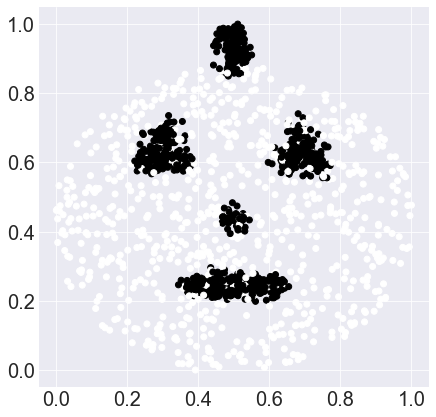

In [353]:
plt.figure(figsize=(7,7))
plt.scatter(rbf_dev_train[:, 0], rbf_dev_train[:, 1], c = y_train)
plt.show()

## Task 2: Radial basis function neural network

In [2]:
from rbf_net import RBF_Net

### 2a. Network initalization

You will use K-means to initialize the RBF hidden layer prototypes and sigmas.

1. Copy over your `kmeans.py` from your previous project. If your K-means clustering code isn't working properly, you may use `scipy` functions in this project instead, but at a 1 point reduction. Check out `scipy.cluster.vq.kmeans`.

2. Implement the method templates in `rbf.py` that initialize the hidden layer of the neural network:
    - Finish writing the constructor
    - `get_num_hidden_units`
    - `get_num_output_units`
    - `avg_cluster_dist`: Compute the average distance between each cluster center found by K-means and all the points assigned to the same cluster.
    - `initialize`: Use K-means to set the Gaussian hidden unit centers (**prototypes**) and standard deviations (**sigmas**).


In [3]:
from kmeans import KMeans

#### Test `avg_cluster_dist`

In [285]:
np.random.seed(0)

# N = 10 samples, M = 5 features
test_data = np.random.normal(size=(10, 5))
# 4 hidden units / prototypes, each has 5 features
test_centroids = np.random.normal(size=(4, 5))
# Each sample assigned to one of 4 hidden unit prototypes
test_assignments = np.random.randint(low=0, high=4, size=(10,))
kmeansObj = KMeans()

test_net = RBF_Net(4, 3)
print(f'Number of hidden units in your net is {test_net.get_num_hidden_units()} and should be 4')
print(f'Number of output units in your net is {test_net.get_num_output_units()} and should be 3')
test_clust_mean_dists = test_net.avg_cluster_dist(test_data, test_centroids, test_assignments, kmeansObj)

print(f'Your avg within cluster distances are\n{test_clust_mean_dists} and should be\n[2.23811 3.94891 3.12267 3.4321]')

Number of hidden units in your net is 4 and should be 4
Number of output units in your net is 3 and should be 3
Your avg within cluster distances are
[2.23811 3.94891 3.12267 3.4321 ] and should be
[2.23811 3.94891 3.12267 3.4321]


#### Test `initialize`

In [255]:
test_net.initialize(test_data)

print(f'Your prototypes have shape {test_net.get_prototypes().shape} and the shape should be (4, 5).')
print(f'Your hidden unit sigmas have shape {test_net.sigmas.shape} and the shape should be (4,).')

Your prototypes have shape (4, 5) and the shape should be (4, 5).
Your hidden unit sigmas have shape (4,) and the shape should be (4,).


#### Test initialization methods

In the cell below, write test code for your RBF network initialization:
- Create a new RBF network with 7 hidden units and 2 output classes.
- Call the `initalize` method on it, passing in the training data.
- Create a class color-coded scatterplot of the training data with an equal axis aspect ratio, like above, now with the prototypes clearly marked with a different marker and/or color.

You should see fairly evenly distributed prototypes, with one in most, if not all, "pockets" of samples belonging to a single class.

In [333]:
# Keep me
np.random.seed(0)
# Create your network here
rbf = RBF_Net(7,2)
rbf.initialize(rbf_dev_train)



Start initializing
Finish initializing


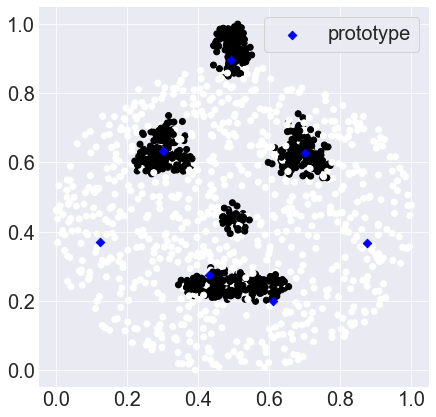

In [355]:
# Your plot here
plt.figure(figsize=(7,7))
plt.scatter(rbf_dev_train[:, 0], rbf_dev_train[:, 1], c = y_train)
plt.scatter(rbf.prototypes[:, 0], rbf.prototypes[:, 1], c='b', marker="D", label="prototype")
plt.legend(frameon=True)
plt.show()

**Question 1:** Do you think the prototypes enable the RBF network to learn the data well? Why or why not?

**Answer 1:**
I think the RBF network would not learn so well because the prototypes do not really represent the positional characteristic of each class. The group of data colored black in the center of the plot should have a prototype but it does not. Also the prototype at the bottom of the plot is lying on the boundary of data classified as two different classes, so it is not very representative, as the data points colored white that lie very close to that prototype might be mistaken for the other class. With these prototypes the network may pick up wrong class representations

### 2b. Compute hidden and output layer activations

Implement the following methods so that you can train your RBF network:
- `hidden_act`: Computes hidden layer activation values: Determines the similarity between hidden layer prototypes with the input data.
- `output_act`: Computes output layer activation values: Multiply hidden unit activation by output unit weights.

**Hidden unit activation**:

The activation of hidden unit $j$ to data sample $i$ is computed according to $$H_{ij} = \exp \left (-\frac{\text{dist} \left (\vec{x}_i, \vec{c}_j \right )^2}{2\sigma_j^2 + \epsilon}\right )$$ 
where $\vec{x_i}$ is the data sample, $\vec{c_j}$ is the prototype (center) of the hidden unit, $\sigma_j$ is the hidden unit's standard deviation, $\epsilon$ is a small number (e.g. 1e-8), and $dist(\cdot, \cdot)^2$ is the **squared** Euclidean distance.

#### Test hidden_act

In [318]:
np.random.seed(1)

# N = 3 samples, M = 5 features
test_data = np.random.normal(size=(3, 5))
# 4 hidden units / prototypes, each has 5 features
test_centroids = np.random.normal(size=(4, 5))
# Each sample assigned to one of 4 hidden unit prototypes
test_sigmas = np.random.uniform(size=(4,))
test_wts = 2*np.random.uniform(size=(4+1, 3)) - 1

test_net = RBF_Net(4, 3)
test_net.prototypes = test_centroids
test_net.sigmas = test_sigmas
test_net.wts = test_wts
test_h_act = test_net.hidden_act(test_data)
print(f'Your hidden layer activation is\n{test_h_act}\n\nand should be')
print('[[0.      0.      0.00009 0.00033]\n [0.00013 0.      0.00004 0.00014]\n [0.      0.      0.      0.00001]]')

Your hidden layer activation is
[[0.      0.      0.00009 0.00033]
 [0.00013 0.      0.00004 0.00014]
 [0.      0.      0.      0.00001]]

and should be
[[0.      0.      0.00009 0.00033]
 [0.00013 0.      0.00004 0.00014]
 [0.      0.      0.      0.00001]]


#### Test output_act

In [259]:
test_out_act = test_net.output_act(test_h_act)
print(f'Your output layer activation is\n{test_out_act}\n\nand should be')
print('[[-0.72136  0.61505 -0.20481]\n [-0.72151  0.61487 -0.20466]\n [-0.72144  0.61479 -0.20465]]')

Your output layer activation is
[[-0.72136  0.61505 -0.20481]
 [-0.72151  0.61487 -0.20466]
 [-0.72144  0.61479 -0.20465]]

and should be
[[-0.72136  0.61505 -0.20481]
 [-0.72151  0.61487 -0.20466]
 [-0.72144  0.61479 -0.20465]]


### 2c. Learn network weights using linear regression

To train your RBF network, you will need to find optimal weights between hidden and output layer neurons to allows your network to accurately classify the training data (i.e. learn from the data). An efficient solution is to use linear regression to solve a least square problem: minimizing the squared difference between the *hidden layer activations* and the *true data classes*.

In `rbf.py`, implement `linear_regression(A, y)`. To do this, adapt your code in `linear_regression` to use your QR solver.

#### Test linear regression

Running the following test code should generate a familar regression fit to the Iris data.

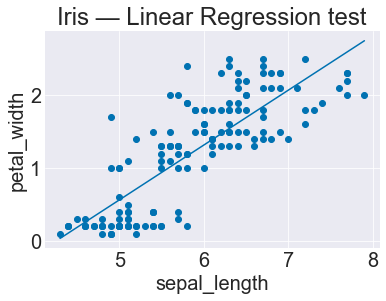

In [260]:
df = pd.read_csv('https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv')
iris = df[['sepal_length', 'petal_width']].to_numpy()

num_hidden_units = 1
num_classes = 4
net = RBF_Net(num_classes=num_classes, num_hidden_units=num_hidden_units)
iris_x = np.reshape(iris[:, 0], [len(iris), 1])
iris_y = np.reshape(iris[:, 1], [len(iris), 1])
iris_c = net.linear_regression(iris_x, iris_y)

line_x = np.linspace(iris_x.min(), iris_x.max())
line_y = line_x * iris_c[0] + iris_c[1]
plt.scatter(iris_x, iris_y)
plt.plot(line_x, line_y)
plt.title('Iris — Linear Regression test')
plt.xlabel('sepal_length')
plt.ylabel('petal_width')
plt.show()

### 2d. Train your RBF Network

Implement the following methods then train your neural network! In the cell below, train a RBF network with 10 hidden units on the RBF dev dataset. **If everything is working, you should get >=88% accuracy on the training set and >=89% on the test set.**

- `train`: Determine the optimal output layer weights that fit hidden layer activation using linear regression.
- `predict`: Use trained network (after learning) to predict the class of data.
- `accuracy`: Compute the accuracy by comparing the network predicted and actual class for each data sample.



In [235]:
rbf_model = RBF_Net(10, 2)
rbf_model.train(rbf_dev_train, y_train)
y_train_pred = rbf_model.predict(rbf_dev_train)
y_test_pred = rbf_model.predict(rbf_dev_test)

Start initializing
Finish initializing


In [268]:
# Training set accuracy
train_acc = rbf_model.accuracy(y_train, y_train_pred)
print(f'train accuracy: {train_acc}')

train accuracy: 0.895625


In [269]:
# Test set accuracy
test_acc = rbf_model.accuracy(y_test, y_test_pred)
print(f'test accuracy {test_acc}')

test accuracy 0.9025


## Task 3: Handwritten digit classification: MNIST data

You will train a RBF network on a "real" image dataset of handwritten number digits:
- 60,000 images in training set, 10,000 images in test set.
- Each image is 28x28 pixels.
- The images are grayscale (no RGB colors).
- Each image (data sample) contains ONE of 10 numeric digit $0, 1, 2, \ldots, 8, 9$.

The goal is to train your network so that it can correctly predict the numeric digit in an image.

More information about MNIST: http://yann.lecun.com/exdb/mnist/

### 3a. Load in and look at MNIST dataset

- Use the numpy function `load` to load in the MNIST train/test data and the associated class labels.
- Create a 5x5 grid showing the first 25 images in the dataset. It should "look good" (e.g. turn off tick marks).

In [335]:
# Load data here
x_train = np.load("data/mnist_train_data.npy")
x_test = np.load("data/mnist_test_data.npy")
y_train = np.load("data/mnist_train_labels.npy")
y_test = np.load("data/mnist_test_labels.npy")

In [271]:
print(f'Your training set shape is {x_train.shape} and should be (60000, 28, 28).')
print(f'Your training classes shape is {y_train.shape} and should be (60000,).')
print(f'Your test set shape is {x_test.shape} and should be (10000, 28, 28).')
print(f'Your test classes shape is {y_test.shape} and should be (10000,).')

Your training set shape is (60000, 28, 28) and should be (60000, 28, 28).
Your training classes shape is (60000,) and should be (60000,).
Your test set shape is (10000, 28, 28) and should be (10000, 28, 28).
Your test classes shape is (10000,) and should be (10000,).


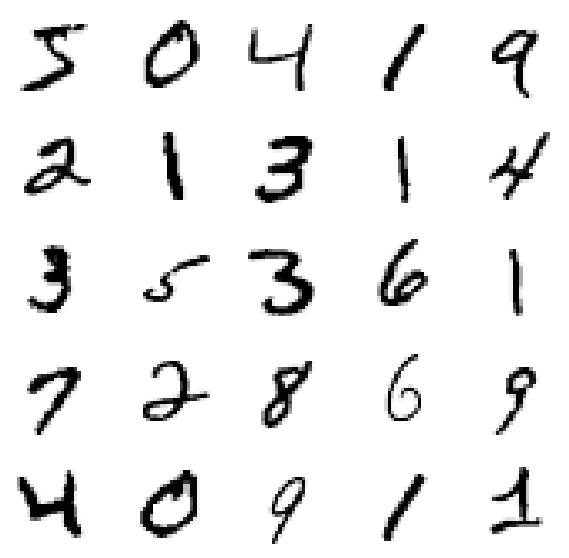

In [208]:
# 5x5 plot here
def img_plot(imgs):
    '''Create a 5x5 grid of images
    
    Parameters:
    -----------
    face_imgs: ndarray. shape=(N, img_y, img_x).
        Grayscale images to show.
    
    TODO:
    - Create a 5x5 grid of plots of a legible size
    - In each plot, show the grayscale image and make the title the person's name.
    '''
    fig, axs = plt.subplots(5, 5, figsize=(10,10))
    for i in range(len(imgs)):
        img = imgs[i]
        axs[int(i/5),i%5].imshow(img)
        axs[int(i/5),i%5].set_xticks([])
        axs[int(i/5),i%5].set_yticks([])
    plt.show()
    
img_plot(x_train[:25])

In [272]:
for i in range(10):
    print(f'{i}: {np.where(y_train[:1600] == i)[0].shape[0]}')

0: 150
1: 180
2: 156
3: 152
4: 171
5: 147
6: 154
7: 185
8: 141
9: 164


### 3b. Preprocess data

- Flatten non-leading dimensions of the train and test sets. For example, the training set should go from (60000, 28, 28) to (60000, 784). **Do not hard code this!** Your code should work for any data with three dimensions.
- Normalize so that the maximum possible value in each image is 1 (and the minimum possible is 0) by dividing by 255.

In [6]:
preprocessed_x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]*x_train.shape[2]))/255.0
preprocessed_x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]*x_test.shape[2]))/255.0

### 3c. Train and assess performance on MNIST

Train a RBF network on MNIST. **Your goal is to get >=90% accuracy on both train and test sets.**

**Tips:**
- Depending on your laptop or machine you are using, training could take many hours if you use the full 60,000 sample training set. Select a subset to train on (e.g. ~1500) that takes a reasonable amount of time (e.g. minutes). You should be able to hit your accuracy goals without too much data, effort, or time.
- Do not pare down the test set (i.e. it should remain at 10,000 samples).
- Use the code below to visualize your hidden layer prototypes to help with debugging (assumes your network is called `mnist_net`). Your prototypes should look like images of certain digits, perhaps a little blurrier.

In [9]:
import time

In [11]:
print(preprocessed_x_train[:2000].shape)

(2000, 784)


In [338]:
mnist_net = RBF_Net(120, 10)
start = time.time()
mnist_net.train(preprocessed_x_train[:2000], y_train[:2000])
print (f'train time {time.time() - start}')

Start initializing
Finish initializing
train time 1052.2623617649078


In [45]:
# train acc
y_train_pred = mnist_net.predict(preprocessed_x_train[:2000])
train_acc = mnist_net.accuracy(y_train[:2000], y_train_pred)
print(f'Train accuracy: {train_acc}')
# test acc
y_test_pred = mnist_net.predict(preprocessed_x_test)
test_acc = mnist_net.accuracy(y_test, y_test_pred)
print(f'Test accuracy: {test_acc}')

Train accuracy: 0.9225
Test accuracy: 0.9012


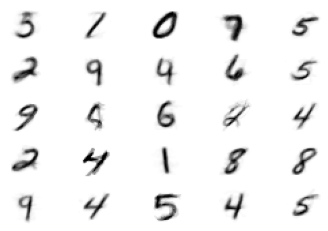

In [46]:
# Visualize network hidden layer prototypes
prototypes = mnist_net.get_prototypes()
prototypes = np.reshape(prototypes, [prototypes.shape[0], 28, 28])

cols = rows = 5
fig, axes = plt.subplots(nrows=rows, ncols=cols)
for i in range(rows):
    for j in range(cols):
        axes[i, j].imshow(prototypes[i*rows + j])
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

**Question 2:** Which part of the training process takes the longest?

**Answer 2:** The k-means clustering step takes the longest

**Question 3:** What accuracy did you achieve on the training set? List all parameters that you needed to set (e.g. number of training samples, number hidden units, etc).

**Answer 3:** I achieve 0.9225 on the training set. The parameters are:
- Number of hidden units: 120
- Number of training samples: 2000
- Number of iteration for batch cluster in initialization: 5


**Question 4:** Using the same parameters to get the training accuracy that you reported in Question 3, what test accuracy did you achieve?

**Answer 4:** I achieve 0.9012 on the test set with the same set of parameters

### 3d. Visualize prototypes using network weights

Now that you've trained the network to recognize handwritten digits, let's visualize the dominant factors that the network learns to rely on to make each prediction.

Create a 10 x 5 plot showing images of the 5 "most influential hidden layer prototypes" that contribute to predicting each of the 10 output classes. These are defined as the hidden layer prototypes that have the 5 largest weights going from the hidden layer to the output layer. *Recall that each hidden unit prototype has the same shape as a single data sample so each image in your grid should be 28x28.*

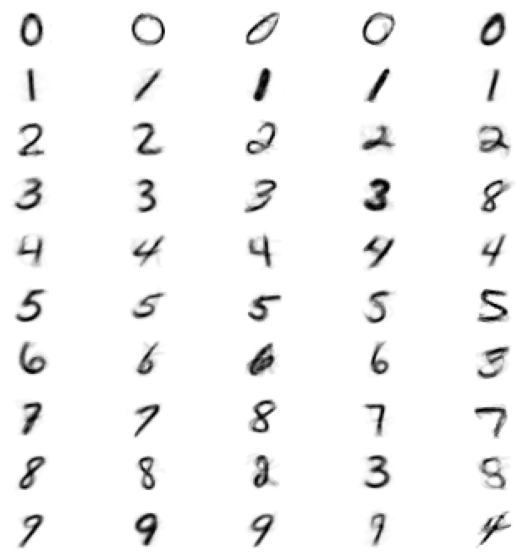

In [356]:
weights = mnist_net.wts
prototypes = mnist_net.get_prototypes()
prototypes = np.reshape(prototypes, [prototypes.shape[0], 28, 28])
dominant_prototypes_ind = np.zeros(50)

for i in range(weights.shape[1]):
    w = weights[:, i]
    dominant_prototypes_ind[i*5:i*5+5] = np.flip(np.argsort(w)[-5:])
dominant_prototypes_ind = dominant_prototypes_ind.astype(int)
fig_dom, axes_dom = plt.subplots(10, 5,figsize=(10,10))
for i in range(10):
    for j in range(5):
        axes_dom[i, j].imshow(prototypes[dominant_prototypes_ind[i*5 + j]])
        axes_dom[i, j].set_xticks([])
        axes_dom[i, j].set_yticks([])


**Question 5:** Interpret what each row of your 10x5 grid of images means. Did any of the top prototypes surprise you?

**Answer 5:** Each row of the grid contains the prototypes whose weights contribute most to the output, which means that they are the prototypes/images that most representative of the class. The 5th top prototype for number 3 looks like an 8, but it is not very suprising as number 3 actually have many similarities to number 8. Same thing is observed for the 5th top prototype for number 9, which looks more like a 4. Most surprising to me is the 3th top prototype of number 7, which looks like an 8, as 7 and 8 does not share many things in common

## Task 4: RBF neural networks for regression

In this task you will make modest changes and configure your RBF neural network to enable it to perform regression rather than solve classification problems.

### Task 4a. Plot regression curve data

Download and load in the regression "x values" (`'rbf_regression_x.npy'`) and "y values" (`'rbf_regression_y.npy'`). Create a plot of the curve that you on which will perform regression.

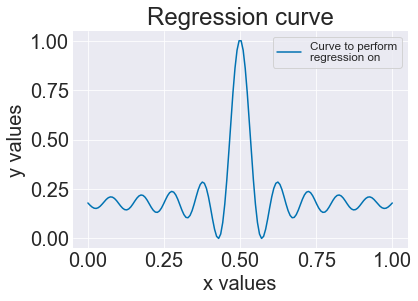

In [360]:
x_values = np.load('data/rbf_regression_x.npy')
y_values = np.load('data/rbf_regression_y.npy')
plt.plot(x_values, y_values, label="Curve to perform\nregression on")
plt.legend(fontsize='xx-small',frameon=True)
plt.xlabel("x values")
plt.ylabel("y values")
plt.title("Regression curve")
plt.show()

### 4b. Implement a RBF Neural Network for Regression 

Implement the methods in the `RBF_Reg_Net` class. In every case except the constructor, this involves copy-pasting code from your classification network and making small changes.

Note that the hidden unit variance gain parameter ($g$) modifies the RBF function as follows:

$$H_{ij} = \exp \left (-\frac{\text{dist} \left (\vec{x}_i, \vec{c}_j \right )^2}{2g*\sigma_j^2 + \epsilon}\right )$$

#### Test: RBF regression neural network

- Create an object of the `RBF_Reg_Net` network. Configure it with:
    - 1 output neuron
    - 50 hidden units
    - the default value for the hidden unit variance gain.
- Train the network and have it predict y values at the training x values.
- Plot the original (x, y) values on the curve, and along with the predicted y values at the same x values.

**If everything is working, the regression performed by your network should produce an almost "perfect" reconstruction of the original data curve.**

In [358]:
from rbf_net import RBF_Reg_Net

In [361]:
reg_rbf = RBF_Reg_Net(50,1)
reg_rbf.train(x_values, y_values)
y_pred = reg_rbf.predict(x_values)

Start initializing
Finish initializing


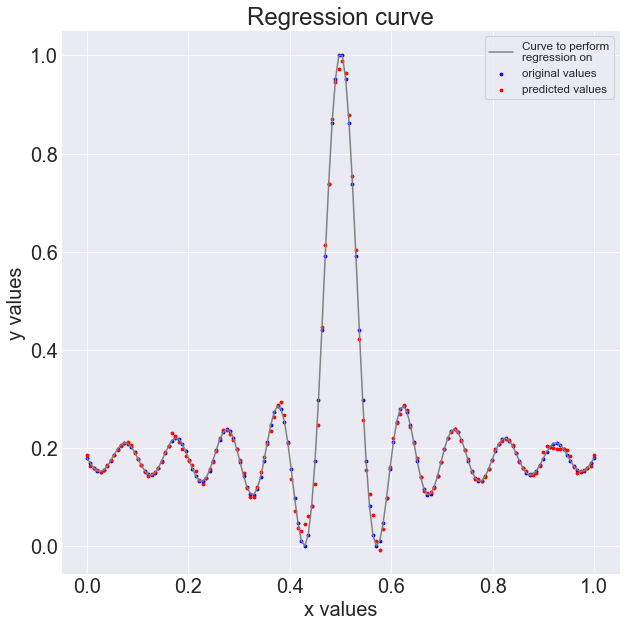

In [362]:
plt.figure(figsize=(10,10))
plt.plot(x_values, y_values, "#828181", label="Curve to perform\nregression on")
plt.xlabel("x values")
plt.ylabel("y values")
plt.title("Regression curve")
plt.scatter(x_values, y_values, 8, 'b', label="original values")
plt.scatter(x_values, y_pred, 8, 'r', label="predicted values")
plt.legend(fontsize='xx-small',frameon=True)
plt.show()

### 4c. Analysis of RBF Regression Neural Network

**Question 6:** Below, train the RBF regression network again, but with the hidden unit variance gain set to 1 .Superimpose the predicted regression curve with the original curve in the same plot. What happens and why?

**Answer 6:** The predicted values with g=1 do not fit the curve as well as when g=5. This happens because the way we set g value affects how the hidden activation level of each data point. If g is low, the model is less tolerant for differences between data points and prototypes, so it may fail to capture the overall trend of the dataset

In [367]:
reg_rbf = RBF_Reg_Net(50,1,1)
reg_rbf.train(x_values, y_values)
y_pred = reg_rbf.predict(x_values)

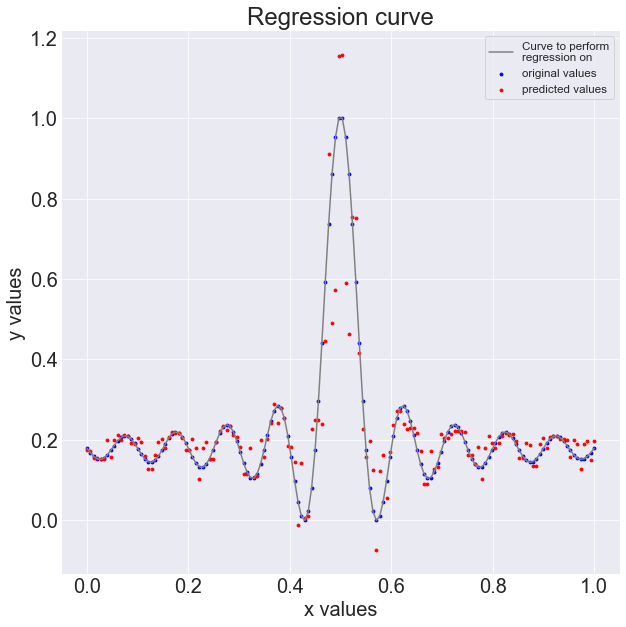

In [369]:
plt.figure(figsize=(10,10))
plt.plot(x_values, y_values, "#828181", label="Curve to perform\nregression on")
plt.xlabel("x values")
plt.ylabel("y values")
plt.title("Regression curve")
plt.scatter(x_values, y_values, 8, 'b', label="original values")
plt.scatter(x_values, y_pred, 8, 'r', label="predicted values")
plt.legend(fontsize='xx-small',frameon=True)
plt.show()

**Question 7:** Run an experiment where you fix the hidden unit variance gain parameter to 5 and vary the number of hidden units in the network between 5 and 50. Create a plot showing the MSSE of the predictions vs the original data for each networks with a different number of hidden units. Explain what the plot reveals about the number of hidden units in the network.

**Answer 7:** MSSE decreases at a generally decreasing rate as we increase the number of hidden units. At a certain point (in this case, when there are 30 hidden units) the model reaches its diminishing return, the number of hidden units does not affect or insignificantly affect MSSE

In [372]:
msse = np.zeros(10)
for i in range(1, 11):
    reg_rbf = RBF_Reg_Net(i*5,1,5)
    reg_rbf.train(x_values, y_values)
    y_pred = reg_rbf.predict(x_values)
    msse[i-1] = reg_rbf.mean_sse(y_values, y_pred)

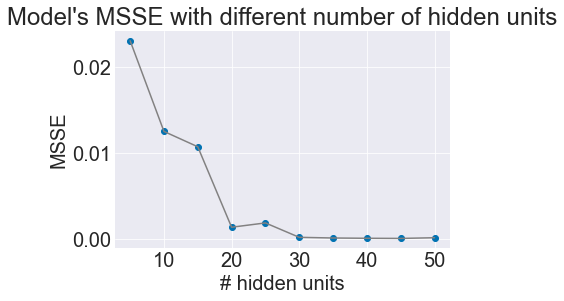

In [373]:
plt.plot(np.arange(5, 51, 5), msse, "#828181")
plt.scatter(np.arange(5, 51, 5), msse)
plt.xlabel("# hidden units")
plt.ylabel("MSSE")
plt.title("Model's MSSE with different number of hidden units")
plt.show()

**Question 8:** Run an experiment where you fix the number of hidden units to 10 and vary the hidden unit variance gain parameter between 2 and 50. Create a plot showing the MSSE of the predictions vs the original data for each networks with a different gain parameter value. Explain what the plot reveals about the hidden unit variance in the network.

**Answer 8:** MSSE fluctuates with different values of g, but it is highest when g is small (g <= 2). From g = 6 to g = 50, MSSE is generally low. I attribute the fluctuation to the randomness of K-means. This shows that increasing g does not decrease MSSE, but it is better to have g at a not too low value.

In [417]:
msse = np.zeros(25)
for i in range(1, 26):
    reg_rbf = RBF_Reg_Net(10,1,i*2)
    reg_rbf.train(x_values, y_values)
    y_pred = reg_rbf.predict(x_values)
    msse[i-1] = reg_rbf.mean_sse(y_values, y_pred)
# print(msse)

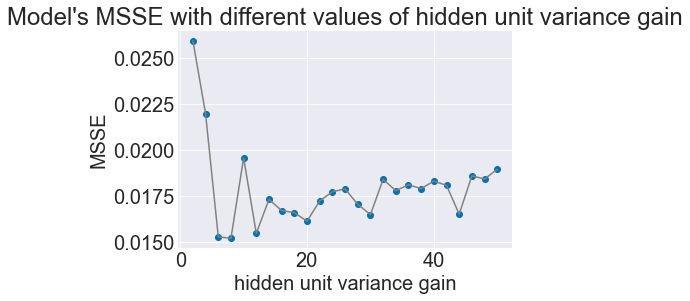

In [418]:
plt.plot(np.arange(2, 51, 2), msse, "#828181")
plt.scatter(np.arange(2, 51, 2), msse)
plt.xlabel("hidden unit variance gain")
plt.ylabel("MSSE")
plt.title("Model's MSSE with different values of hidden unit variance gain")
plt.show()

## Extensions

To receive credit for any extension, you must:
- Not modify / prevent any code from the core project from working (e.g. make a copy before changing). In other words, **the notebook test code should still work!**
- **You must describe what you did and what you found in detail**. This includes a summary of parameter values used in your simulations.
- Include (*labeled!*) plots and/or numbers to present your results.
- Write up your extensions below or in a separate notebook.

**Rule of thumb: one deep, thorough extension is worth more than several quick, shallow extensions!**

### 1) Improve performance on MNIST with PCA

Using all 768 features (pixels) in each image may not be very helpful for classification. For example, pixels around the border are almost always white. Transform the dataset(s) using PCA to compress the number of features before training your RBF network. Experiment with PCA to improve classification accuracy and runtime performance.

I performed PCA on the first 2000 samples of the train set of mnist dataset. Looking at the elbow plot, I see that keeping the first 75 PCs will retain almost 90% of the data features, so I decided to project the train set on the PCA space of first 75 PCs. I also projected the test set onto the same space.

PCA processing time: 3.254544973373413s


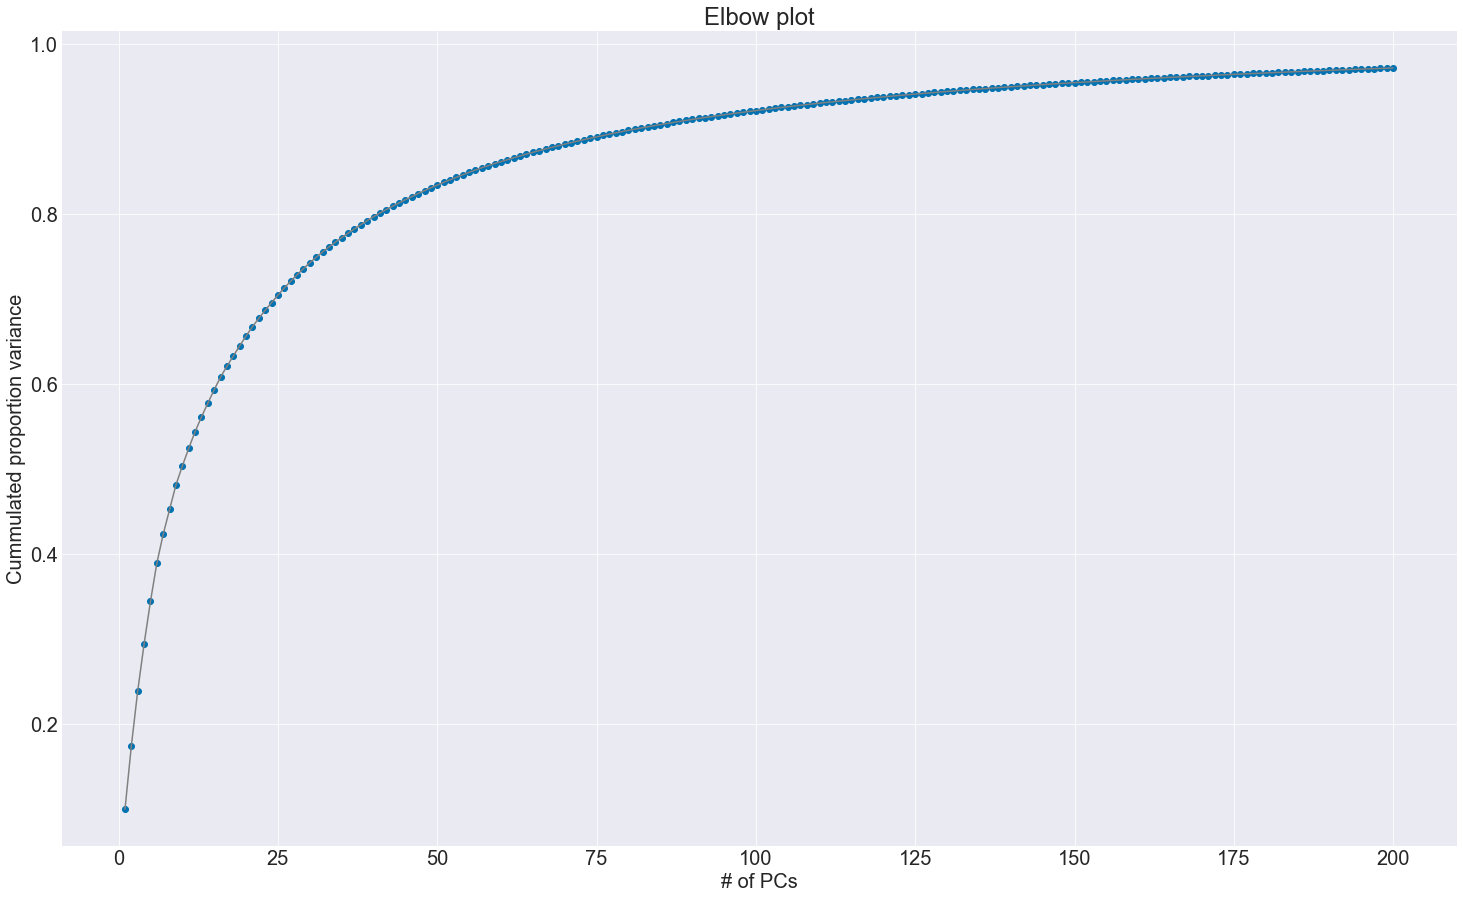

In [53]:
from pca_cov import PCA_COV
import pandas as pd

mnist_df = pd.DataFrame(data=preprocessed_x_train[:2000])
mnist_pca = PCA_COV(mnist_df)
vars_list = [i for i in range(len(mnist_df.columns))]
start = time.time()
mnist_pca.pca(vars_list)
print(f'PCA processing time: {time.time() - start}s')
mnist_pca.elbow_plot(200)
plt.show()


In [60]:
number_of_pcs = 75
pcs_to_keep = np.arange(number_of_pcs)
mnist_train_proj = mnist_pca.pca_project(pcs_to_keep).astype(float)
mean_mnist = np.mean(preprocessed_x_train[:2000],axis=0)
mnist_test_proj = (preprocessed_x_test - mean_mnist)@mnist_pca.e_vecs[:, :number_of_pcs].astype(float)

<ipython-input-60-d058f097c373>:3: ComplexWarning: Casting complex values to real discards the imaginary part
  mnist_train_proj = mnist_pca.pca_project(pcs_to_keep).astype(float)
<ipython-input-60-d058f097c373>:5: ComplexWarning: Casting complex values to real discards the imaginary part
  mnist_test_proj = (preprocessed_x_test - mean_mnist)@mnist_pca.e_vecs[:, :number_of_pcs].astype(float)


In [61]:
pca_mnist_net = RBF_Net(120, 10)
start = time.time()
pca_mnist_net.train(mnist_train_proj, y_train[:2000])
print (f'train time {time.time() - start}s')


Start initializing
Finish initializing
train time 94.02462100982666s


In [65]:
# train acc
pca_y_train_pred = pca_mnist_net.predict(mnist_train_proj)
pca_train_acc = pca_mnist_net.accuracy(y_train[:2000], pca_y_train_pred)
print(f'Train accuracy: {pca_train_acc}')
# test acc
pca_y_test_pred = pca_mnist_net.predict(mnist_test_proj)
pca_test_acc = pca_mnist_net.accuracy(y_test, pca_y_test_pred)
print(f'Test accuracy: {pca_test_acc}')

Train accuracy: 0.9255
Test accuracy: 0.9054


Using the PCA projected train set turns out to be very time efficient. It reduces the runtime from 1052s to 94s, which is more than 10 times. The accuracy on test set and train set is not negatively affected by using PCA projection. I attribute this to the fact that many of the 278 pixels of an image represent the white background, which does not hold much information. Taking all of these pixels as input for the RBF net will put extra burden on the computation while not necessarily improve the accuracy. Using PCA to reduce the principle components that does not contribute much to the meaning of the data is very useful in this case

### 2) Visualize network predictions

Make visualizations to show and interpret the MNIST network predictions. Lots of possibilities, here are a few specific ideas:
- Make show a grid of test samples labeled with their predicted digit.
- Analyze if the network performance favors accuracy for certain digits and not others.
- Are errors on certain classes correlated in any way? Does it depend on their digit similarity (e.g. 1 looks like a 7, but not a 0).
- Make and interpret a confusion plot.

### 3) Explore parameter space

When training your RBF network on MNIST, you had to pick some parameter values to use by hand. Pick one or more parameters and systematically vary them to quantify their effect on accuracy and simulation time.

### 4) Initialization schemes

Research, test out, and quantify the performance of different techniques to set the hidden unit prototypes and sigmas. For example, an alternative way to initialize the prototypes is to perform K-means to cluster each class *separately*. 

### 5) Other datasets

Use your RBF network to classify other datasets.

### 6) SVD-based linear regression

Implement a SVD-based linear regression method, which is both fast and numerically accurate. In the equation $Ac = y$ The weights $c$ can be solved via the following matrix equation: $$c = A^+y$$ where $A^+$ is the pseudo inverse of the matrix of RBF hidden layer activations $A$ (*data matrix*) and the correct classes $y$.

Relying on numpy to figure out the pseudoinverse would be a mini extension, computing the pseudoinverse yourself would be a larger extension.

For this extension, I implement SVD and pseudo inverse from scratch. Basically, SVD is an extension of eigenvectors and eigenvalues that can handle non-square matrices and allow us to take pseudo inverse of them, which cannot be done directly with eigenvectors and eigenvalues. 

Any matrix shape (n, m) can be written as:
<img src="img/SVD.png" width="200"/>
<center>Singular value decomposition of matrix A</center>

This is the Singular Decomposition Vector of matrix A. Every matrix A has a set of singular values, which are the eigenvalues of $A^{T}A$. The eigenvalues are sorted in decreasing order. The number of positive singular values of matrix A is the rank of matrix A, denoted as r. Going into details of each component, we have:

- $\sum$ is a matrix (shape (n, m)) whose main diagonal (going from top left) contains the square root of the singular values, $\sigma_i$. The reduced matrix of $\sum$, $D$, includes up to the rth row and rth column of $\sum$. The shape of $D$ is (r, r)
- V is an orthogonal matrix of corresponding eigenvectors, with each vector lying on a column. The reduced matrix of V is $V_r$, which includes up to the rth eigenvectors. The shape of $V_r$ is (m, r)
- U is an orthogonal matrix whose first r columns are the vectors obtained from $\frac{Av_1}{\sigma_i}$,…, $\frac{Av_r}{\sigma_r}$. The reduced matrix of U, $U_r$, has the shape (n, r)

Using the components of SVD, we can compute the pseudo inverse of a matrix A as:
<img src="img/pinverse.png" width="200"/>
<center>Computation of pseudo inverse of matrix A using SVD components</center>

Source: Lay, David C. Linear Algebra and Its Applications – 3rd ed. update.. Pearson, 2006. Chapter 7, page 471 – 480


In my code, I added a parameter called "mode" in the linear_regression method of class RBF_Net. The default value is "qr", which will calls the qr decomposition solver, so it will not change the code I have run previously. If mode is specified as "pinverse", the linear_regression method will call pinverse method on matrix A, in which SVD method is evoked on matrix A. SVD(A) returns $U_r, D, V_r$, which are used to compute $A^{+}$ in pinverse method. 
The linear_regression method computes the coefficient vector c using the returned value, $A^{+}$, of pinverse(A).  

In [351]:
#test code for pinverse
import scipy

a = np.array([[2,-1,0],[4,3,-2]])
a_inverse = scipy.linalg.pinv(a)
a_inverse_manual = pca_mnist_net.pinverse(a)
print(f'Matrix a:\n{a}')
print(f'Scipy pseudo inverse of a:\n{a_inverse}')
print(f'My pseudo inverse of a:\n{a_inverse_manual}')
print('\n')
b = np.array([[1,-1],[-2,2],[2, -2]])
b_inverse = scipy.linalg.pinv(b)
print(f'Matrix b:\n{b}')
b_inverse_manual = pca_mnist_net.pinverse(b)
print(f'Scipy pseudo inverse of b:\n{b_inverse}')
print(f'My pseudo inverse of b:\n{b_inverse_manual}')
print('\n')

Matrix a:
[[ 2 -1  0]
 [ 4  3 -2]]
Scipy pseudo inverse of a:
[[ 0.31667  0.08333]
 [-0.36667  0.16667]
 [ 0.08333 -0.08333]]
My pseudo inverse of a:
[[ 0.31667  0.08333]
 [-0.36667  0.16667]
 [ 0.08333 -0.08333]]


Matrix b:
[[ 1 -1]
 [-2  2]
 [ 2 -2]]
Scipy pseudo inverse of b:
[[ 0.05556 -0.11111  0.11111]
 [-0.05556  0.11111 -0.11111]]
My pseudo inverse of b:
[[ 0.05556 -0.11111  0.11111]
 [-0.05556  0.11111 -0.11111]]




In [341]:
print("Weight computation with manual pseudo inverse")
pca_mnist_net = RBF_Net(120, 10)
start = time.time()
pca_mnist_net.train(mnist_train_proj, y_train[:2000], "pinverse")
print (f'train time {time.time() - start}s')

Weight computation with manual pseudo inverse
Start initializing
Finish initializing
train time 90.45651507377625s


In [342]:
# train acc
pca_y_train_pred = pca_mnist_net.predict(mnist_train_proj)
pca_train_acc = pca_mnist_net.accuracy(y_train[:2000], pca_y_train_pred)
print(f'Train accuracy: {pca_train_acc}')
# test acc
pca_y_test_pred = pca_mnist_net.predict(mnist_test_proj)
pca_test_acc = pca_mnist_net.accuracy(y_test, pca_y_test_pred)
print(f'Test accuracy: {pca_test_acc}')

Train accuracy: 0.9315
Test accuracy: 0.9073


Using SVD and pseudo inverse that I implemented from scratch to compute the weight still yields the same level of accuracy on train set and test set. This means that the methods are implemented correctly. This also offers us another way to build the linear regression solver.

### 7) Analyze the trained network

Run simulations then analyze and interpret the results. Here are some ideas:
- Visualize and analyze how the prototypes influence the classification results.
- Visualize and analyze how the network weights influence the classification results.

### 8) RBF networks for regression

- Analyze the regression neural network's performance in scenarios when the training set is not equal to the training set.
- Explore and analyze how the RBF network could perform regression on a function with several inputs (e.g. $z = f(x, y)$). Test with real or simulated data.
- Explore and analyze how the RBF network could perform regression on a vector valued function with several outputs (e.g. $(y, z) = f(x)$). Test with real or simulated data.

### 9) Improvement on runtime
Running my rbf with 120 hidden neurons, 5 k-means clutering iterations for intializations, and 2000 training data samples takes 1052 seconds ~ 17.5 minutes, which is pretty long (please see task 3c). I attempted to improve this runtime by modifying my code to be more efficient.

In the RBF_Net class, my old hidden_activation method loops through all data samples to compute the distance to each prototype. 

<img src="img/old_hidden_act.png" width="400"/>
<center>Old hidden_activation method</center>

A more efficient approach is to loop through all the prototypes and compute the distance to each sample. This will better take advantage of numpy operation and involve fewer for loops. 

In the KMeans class, my old initialize_plusplus method and update_label method involves calling dist_data_to_centroids method to create a matrix shape (number of samples, number of centroids) which denotes the distance between data i and centroid j at the ij position. Below is the old initialize_plusplus, update_label, and dist_data_to_centroids method:

<img src="img/old_initialize_plusplus.png" width="400"/>
<center>Old initialize_plusplus method</center>
<img src="img/old_update_label.png" width="400"/>
<center>Old update_label method</center>
<img src="img/old_dist_data_to_centroids.png" width="600"/>
<center>Old dist_data_to_centroids method</center>

This method, though does not use any for loop, is extremely costly in terms of space, as it tiles the data matrix n times with n equivalent to the number of centroids. While the method is efficient for the test code when the data matrix is very small, duplicating the data matrix for larger dataset, for example, the mnist dataset, requires the memory storage to constantly clean up to accomodate for a huge amount of space at one time. This might slow down the program and lead to unnecessarily long runtime. To imporve the efficiency, I loop through each centroid and compute its distance to each data sample. 




In [336]:
mnist_net = RBF_Net(120, 10)
start = time.time()
mnist_net.train(preprocessed_x_train[:2000], y_train[:2000])
print (f'train time {time.time() - start}')
# train acc
y_train_pred = mnist_net.predict(preprocessed_x_train[:2000])
train_acc = mnist_net.accuracy(y_train[:2000], y_train_pred)
print(f'Train accuracy: {train_acc}')
# test acc
y_test_pred = mnist_net.predict(preprocessed_x_test)
test_acc = mnist_net.accuracy(y_test, y_test_pred)
print(f'Test accuracy: {test_acc}')

Start initializing
Finish initializing
train time 220.89680790901184
Train accuracy: 0.923
Test accuracy: 0.9025


With the modification, I managed to reduce the training time from 1052s to 221s which is almost 5 times. 